In [6]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros
import datetime

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer

import logging

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.svm import LinearSVC
#from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import spacy

import gensim
from gensim.models import Word2Vec

from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.layers import LSTM, Embedding, SpatialDropout1D, Dropout

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

import matplotlib.pyplot as plt
%matplotlib inline

ss = StandardScaler()

In [7]:
#! pip install tensorflow
#! pip install spacy
#! pip install keras
#! pip install tensorflow-hub

In [8]:
# import nltk
# nltk.download("popular")

In [9]:
df = pd.read_csv('text_emotion.csv')
#df = pd.read_csv('https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/07/text_emotion.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


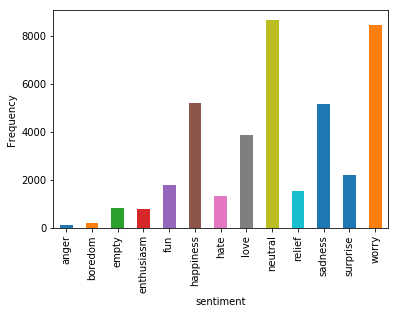

In [11]:
df.groupby('sentiment')['author'].count().plot.bar()
plt.ylabel('Frequency');

In [12]:
df.groupby('sentiment')['author'].count().sort_values()

sentiment
anger          110
boredom        179
enthusiasm     759
empty          827
hate          1323
relief        1526
fun           1776
surprise      2187
love          3842
sadness       5165
happiness     5209
worry         8459
neutral       8638
Name: author, dtype: int64

In [13]:
# # reduce to 5 classes
# df['sentiment'] = df['sentiment'].apply(lambda x: 'neutral' if x == 'empty' else x)
# df['sentiment'] = df['sentiment'].apply(lambda x: 'others' if x in ['anger','boredom','enthusiasm','hate','relief','fun','surprise','love'] else x)
# df.groupby('sentiment')['author'].count().sort_values()

In [14]:
# pos =['enthusiasm','relief','fun','surprise','love','happiness']
# neg =['anger','boredom','hate','sadness','worry']

df['sentiment'] = df['sentiment'].apply(lambda x: 'neutral' if x == 'empty' else x)
# df['sentiment'] = df['sentiment'].apply(lambda x: 'positive' if x in pos else x)
# df['sentiment'] = df['sentiment'].apply(lambda x: 'negative' if x in neg else x)
df.groupby('sentiment')['author'].count().sort_values()

sentiment
anger          110
boredom        179
enthusiasm     759
hate          1323
relief        1526
fun           1776
surprise      2187
love          3842
sadness       5165
happiness     5209
worry         8459
neutral       9465
Name: author, dtype: int64

In [15]:
df.drop(index=df[df['sentiment'].isin(['anger','boredom','enthusiasm'])].index,inplace=True)

In [16]:
#drop unnecessary data
df.drop(columns=['author','tweet_id'],inplace=True)
df.reset_index(drop=True,inplace=True)

In [17]:
#df = df[(df['sentiment'] == 'happiness') | (df['sentiment'] == 'sadness') | (df['sentiment'] == 'neutral')]# | (df['sentiment'] == 'worry')]

In [18]:
labels, features = df.sentiment.factorize()

In [19]:
df['label'] = labels

In [20]:
pd.DataFrame(dict(zip(range(12), features)),index=[0]).transpose()

,0
0,neutral
1,sadness
2,worry
3,surprise
4,love
5,fun
6,hate
7,happiness
8,relief


In [21]:
# # data cleaning to remove @user from content

df['content'] = df['content'].apply(lambda x: ' '.join(
    word for word in x.split(' ') if not word.startswith('@')))

In [22]:
df['content'] = df['content'].apply(lambda x: ' '.join(
    word for word in x.split(' ') if not word.startswith('http')))

In [23]:
def counting(words):
    count = 0
    for word in words.split(' '):
        count+=1
    return count

df['count'] = df['content'].apply(counting)

In [24]:
len(features)

9

In [25]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    stemmer = SnowballStemmer('english')
    text = ' '.join(stemmer.stem(word) for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['content'] = df['content'].apply(clean_text)

In [26]:
#drop empty content

df.drop(index=df[df['content']==''].index,inplace=True)
df.drop(index=df[df['content']=='0'].index,inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38744 entries, 0 to 38951
Data columns (total 4 columns):
sentiment    38744 non-null object
content      38744 non-null object
label        38744 non-null int64
count        38744 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [28]:
df.reset_index(drop=True,inplace=True)

In [29]:
def modelfit(X_train, X_test, y_train, y_test):

    models = [(LogisticRegression(class_weight='balanced', random_state=42, 
                                  multi_class='multinomial', solver='lbfgs',max_iter=500), 
                                   {'C': [0.1, 1, 10], 'penalty':['l2']}),
              (RandomForestClassifier(class_weight='balanced', random_state=42, 
                                      n_estimators=1000), {'max_depth': [10, 20, 30]})]

    class_names = features

    for model, parameters in models:
        print(model)
        clf = GridSearchCV(model, parameters, n_jobs=3, cv=3)
        clf.fit(X_train, y_train)
        print(clf.best_params_)
        y_pred = clf.predict(X_test)
        print('accuracy %s' % accuracy_score(y_pred, y_test))
        print(classification_report(y_test, y_pred, target_names=features))

    return None

## Feature engineering

In [30]:
analyser = SentimentIntensityAnalyzer()

term = ['compound','neg','neu','pos']

for t in term:
    df[t]=df['content'].apply(lambda x : analyser.polarity_scores(x)[t])

In [32]:
en_nlp = spacy.load('en')

parsed_quotes = []
for i, parsed in enumerate(en_nlp.pipe(df.content.values, batch_size=50, n_threads=4)):
    assert parsed.is_parsed
    if (i % 1000) == 0:
        print(i, end=' ')
    parsed_quotes.append(parsed)        

unique_pos = []
for parsed in parsed_quotes:
    unique_pos.extend([t.pos_ for t in parsed])
unique_pos = np.unique(unique_pos)
print(unique_pos)

for pos in unique_pos:
    df[pos+'_prop'] = 0.
    
df = df.reset_index(drop=True)
for i, parsed in enumerate(parsed_quotes):
    if (i % 1000) == 0:
        print(i, end=' ')
    parsed_len = len(parsed)
    for pos in unique_pos:
        count = len([x for x in parsed if x.pos_ == pos])
        df.loc[i, pos+'_prop'] = float(count)/parsed_len

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 ['ADJ' 'ADP' 'ADV' 'AUX' 'CCONJ' 'DET' 'INTJ' 'NOUN' 'NUM' 'PART' 'PRON'
 'PROPN' 'PUNCT' 'SYM' 'VERB' 'X']
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 

In [33]:
# save to file
df.to_csv('formated_9class.csv')

## Model fitting

In [2]:
df = pd.read_csv('formated_9class.csv')

In [34]:
# without countvectorizer

X = df.drop(columns=['label','content','sentiment'])
y = df['label']

X = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


# from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state=42,sampling_strategy='all')
# X_res, y_res = sm.fit_resample(X_train, y_train)

# print(X_res.shape, y_res.shape)

modelfit(X_train, X_test, y_train, y_test)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


{'C': 10, 'penalty': 'l2'}
accuracy 0.22506129823202994
              precision    recall  f1-score   support

     neutral       0.39      0.42      0.40      1862
     sadness       0.27      0.12      0.16      1031
       worry       0.35      0.09      0.14      1687
    surprise       0.07      0.07      0.07       436
        love       0.23      0.46      0.31       768
         fun       0.07      0.09      0.08       355
        hate       0.10      0.55      0.17       264
   happiness       0.22      0.10      0.14      1041
      relief       0.06      0.12      0.08       305

   micro avg       0.23      0.23      0.23      7749
   macro avg       0.20      0.22      0.17      7749
weighted avg       0.27      0.23      0.21      7749

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples

In [37]:
# countvectorizer only

vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=0.0001)
X_vec = vectorizer.fit_transform(df['content'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state = 42, stratify = y)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=features))

accuracy 0.3332042844237966
              precision    recall  f1-score   support

     neutral       0.31      0.62      0.41      1862
     sadness       0.39      0.10      0.16      1031
       worry       0.33      0.55      0.41      1687
    surprise       0.00      0.00      0.00       436
        love       0.54      0.24      0.33       768
         fun       0.00      0.00      0.00       355
        hate       1.00      0.00      0.01       264
   happiness       0.38      0.21      0.27      1041
      relief       0.00      0.00      0.00       305

   micro avg       0.33      0.33      0.33      7749
   macro avg       0.33      0.19      0.18      7749
weighted avg       0.34      0.33      0.28      7749



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
modelfit(X_train, X_test, y_train, y_test)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)
{'C': 1, 'penalty': 'l2'}
accuracy 0.30842689379274746
              precision    recall  f1-score   support

     neutral       0.44      0.34      0.38      1862
     sadness       0.32      0.31      0.31      1031
       worry       0.43      0.27      0.33      1687
    surprise       0.12      0.20      0.15       436
        love       0.43      0.45      0.44       768
         fun       0.13      0.28      0.17       355
        hate       0.20      0.43      0.28       264
   happiness       0.35      0.26      0.29      1041
      relief       0.12      0.26      0.16       305

   micro avg       0.31      0.31      0.31      7749
   macro avg       0.28      0.31      0.28      7749
weighted 

In [39]:
# countvectorizer + features

print(X.shape,X_vec.shape)
X = np.concatenate((X,X_vec.toarray()),axis=1)
print(X.shape)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)

print(X_train.shape,y_train.shape)


(38744, 21) (38744, 11257)
(38744, 11278)
(30995, 11278) (30995,)


In [40]:
modelfit(X_train, X_test, y_train, y_test)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)


KeyboardInterrupt: 

## Word2Vec

In [41]:
wv = gensim.models.KeyedVectors.load_word2vec_format("word2vec_twitter_model.bin", binary=True,unicode_errors='ignore')
wv.init_sims(replace=True)

In [42]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

X = df['content']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)

test_tokenized = X_test.apply(w2v_tokenize_text)
train_tokenized = X_train.apply(w2v_tokenize_text)

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

# model = MultinomialNB()
# model.fit(X_train_word_average, y_train)
# y_pred = logreg.predict(X_test_word_average)

# print(c, ' accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred,target_names=features))



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  


ValueError: Input X must be non-negative

In [44]:
modelfit(X_train_word_average, X_test_word_average, y_train, y_test)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)
{'C': 1, 'penalty': 'l2'}
accuracy 0.2876500193573364
              precision    recall  f1-score   support

     neutral       0.50      0.29      0.37      1862
     sadness       0.32      0.28      0.30      1031
       worry       0.43      0.21      0.28      1687
    surprise       0.12      0.19      0.14       436
        love       0.44      0.47      0.46       768
         fun       0.13      0.34      0.18       355
        hate       0.16      0.52      0.24       264
   happiness       0.34      0.22      0.27      1041
      relief       0.12      0.33      0.18       305

   micro avg       0.29      0.29      0.29      7749
   macro avg       0.28      0.32      0.27      7749
weighted a

## Deep Learning

In [45]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 25
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = df['label']

X_train, X_test, Y_train1, Y_test1 = train_test_split(
    X, Y, test_size=0.20, random_state=42,stratify=Y)

Y_train = pd.get_dummies(Y_train1).values
Y_test = pd.get_dummies(Y_test1).values

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42,sampling_strategy='not majority')
# X_train, Y_train = sm.fit_resample(X_train, Y_train)
# print(X_train.shape, Y_train.shape)



Found 27988 unique tokens.
Shape of data tensor: (38744, 25)
(30995, 25) (30995, 9)
(7749, 25) (7749, 9)


## Normal

In [46]:
filepath='norm_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
earlystop = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(400, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(len(features), activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

epochs = 20
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,\
                    validation_data=(X_test, Y_test), callbacks=[checkpoint, earlystop])


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 400)               801600    
_________________________________________________________________
dense (Dense)                (None, 9)                 3609      
Total params: 2,805,209
Trainable params: 2,805,209
Non-trainable params: 0
_________________________________________________________________
None
Train on 30995 samples, validate on 7749 samples
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/20
30976/30995 [============================>.] - ETA: 0s - loss: 1.9243 - acc: 0.2836
Epoch 00001: val_loss improved from inf to 1.79477, saving model to norm_best_weights.01-0.3577.hdf5
30995/30995 [==============================] - 137s 4ms/sample - loss: 1.9242 - acc: 0.2836 - val_loss: 1.7948 - val_acc: 0.3577
Epoch 2/20
30976/30995 [============================>.] - ETA: 0s - loss: 1.7173 - acc: 0.3865
Epoch 00002: val_loss improved from 1.79477 to 1.74978, saving model to norm_best_weights.02-0.3766.hdf5
30995/30995 [==============================] - 134s 4ms/sample - loss: 1.7174 - acc: 0.3865 - val_loss: 1.7498 - val_acc: 0.3766
Epoch 3/20
30976/30995 [============================>.] - ETA: 0s - loss: 1.5759 - acc: 0.4456
Epoch 00003: val_loss did not improve from 1.74978
30995/30995 [==============================] - 131s 4ms/sample - loss: 1.5760 - acc: 0.4456 - val_loss: 1.7898 - val_acc: 0.3640
Epoch 4/20
30976/30995 [============================>.] - ETA: 0s - los

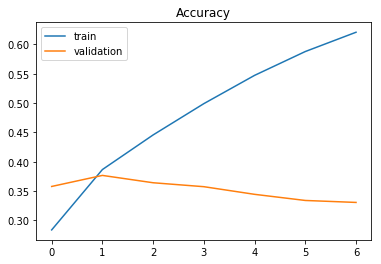

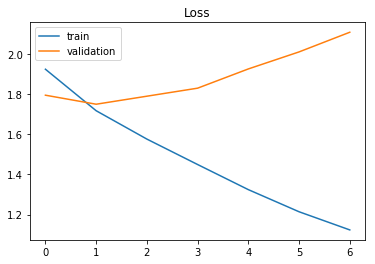

In [47]:
# accr = model.evaluate(X_test,Y_test)
# print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();

In [48]:
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test1, y_pred,target_names=features))

              precision    recall  f1-score   support

     neutral       0.41      0.43      0.42      1862
     sadness       0.29      0.24      0.26      1031
       worry       0.34      0.40      0.37      1687
    surprise       0.12      0.06      0.08       436
        love       0.36      0.46      0.40       768
         fun       0.11      0.05      0.07       355
        hate       0.23      0.28      0.25       264
   happiness       0.29      0.35      0.32      1041
      relief       0.20      0.03      0.06       305

   micro avg       0.33      0.33      0.33      7749
   macro avg       0.26      0.25      0.25      7749
weighted avg       0.31      0.33      0.32      7749



## with glove

In [49]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.twitter.27B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 1193514 word vectors.


In [50]:


EMBEDDING_DIM = 200

# create a weight matrix for words in training docs
embedding_matrix_g = zeros((len(X), EMBEDDING_DIM))
# embedding_matrix = zeros((len(tokenizer.word_index) + 1, 200))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_g[i] = embedding_vector

#print(len(tokenizer.word_index))

filepath='glove_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
earlystop = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)

model = Sequential()
model.add(Embedding(len(X), EMBEDDING_DIM,
                    input_length=X.shape[1], weights=[embedding_matrix_g], trainable=False))
# model.add(Dropout(0.2))

#model.add(SpatialDropout1D(0.2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(400, dropout=0.5, recurrent_dropout=0.5))
# model.add(LSTM(200,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(200))
# model.add(Dropout(0.2))
model.add(Dense(len(features), activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

epochs = 20
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,\
                    validation_data=(X_test, Y_test), callbacks=[checkpoint, earlystop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 200)           7748800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 400)               961600    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 3609      
Total params: 8,714,009
Trainable params: 965,209
Non-trainable params: 7,748,800
_________________________________________________________________
None
Train on 30995 samples, validate on 7749 samples
Epoch 1/20
30976/30995 [============================>.] - ETA: 0s - loss: 1.8648 - acc: 0.3173
Epoch 00001: val_loss improved from inf to 1.76528, saving model to glove_best_weights.01-0.3442.hdf5
30995/30995 [==============================] - 138s 4ms/sample - loss: 1.8648 - acc: 0.3173 - val_loss: 1.7653 - val_acc: 0.3442
Epoch 2/20

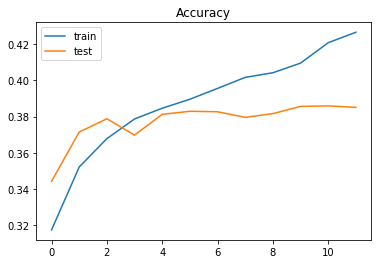

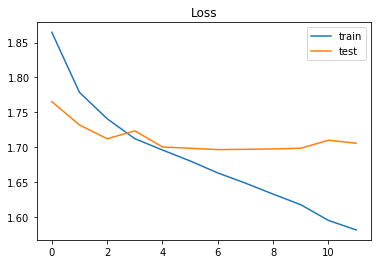

In [51]:
# accr = model.evaluate(X_test,Y_test)
# print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [52]:
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test1, y_pred,target_names=features))

              precision    recall  f1-score   support

     neutral       0.40      0.62      0.49      1862
     sadness       0.38      0.15      0.21      1031
       worry       0.38      0.46      0.42      1687
    surprise       0.22      0.03      0.05       436
        love       0.50      0.43      0.46       768
         fun       0.12      0.01      0.02       355
        hate       0.38      0.24      0.30       264
   happiness       0.33      0.46      0.39      1041
      relief       0.28      0.07      0.11       305

   micro avg       0.39      0.39      0.39      7749
   macro avg       0.33      0.27      0.27      7749
weighted avg       0.36      0.39      0.35      7749



## with word2vec

In [53]:
########################################
## prepare embeddings
########################################
print('Preparing embedding matrix')

EMBEDDING_DIM = 400

from numpy import zeros
# nb_words = min(MAX_NB_WORDS, len(word_index))+1
# embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
embedding_matrix_wv = zeros((len(X), EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in wv.vocab:
        embedding_matrix_wv[i] = wv.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix_wv, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 20442


In [54]:

MAX_NB_WORDS = len(X)

filepath='word2vec_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
earlystop = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)
    
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                    input_length=X.shape[1], weights=[embedding_matrix_wv], trainable=False))
# model.add(Dropout(0.2))

#model.add(SpatialDropout1D(0.1))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(200,return_sequences=True))
model.add(LSTM(400, dropout=0.5, recurrent_dropout=0.5))
# model.add(LSTM(200,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(200))
# model.add(Dropout(0.2))
model.add(Dense(len(features), activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

epochs = 20
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,\
                    validation_data=(X_test, Y_test), callbacks=[checkpoint, earlystop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 400)           15497600  
_________________________________________________________________
lstm_2 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 3609      
Total params: 16,782,809
Trainable params: 1,285,209
Non-trainable params: 15,497,600
_________________________________________________________________
None
Train on 30995 samples, validate on 7749 samples
Epoch 1/20
30976/30995 [============================>.] - ETA: 0s - loss: 1.9145 - acc: 0.2979
Epoch 00001: val_loss improved from inf to 1.80379, saving model to word2vec_best_weights.01-0.3524.hdf5
30995/30995 [==============================] - 168s 5ms/sample - loss: 1.9144 - acc: 0.2978 - val_loss: 1.8038 - val_acc: 0.3524
Epo

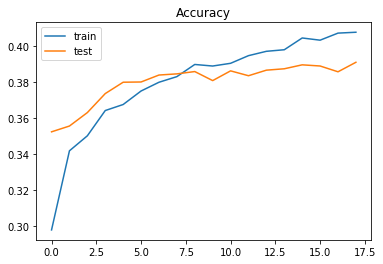

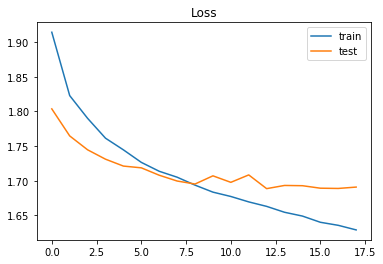

In [55]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [56]:
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test1, y_pred,target_names=features))

              precision    recall  f1-score   support

     neutral       0.41      0.61      0.49      1862
     sadness       0.41      0.16      0.23      1031
       worry       0.36      0.53      0.43      1687
    surprise       0.25      0.01      0.02       436
        love       0.52      0.41      0.46       768
         fun       0.17      0.00      0.01       355
        hate       0.42      0.19      0.26       264
   happiness       0.34      0.45      0.38      1041
      relief       0.28      0.02      0.03       305

   micro avg       0.39      0.39      0.39      7749
   macro avg       0.35      0.26      0.26      7749
weighted avg       0.38      0.39      0.35      7749



    100% |████████████████████████████████| 81kB 2.5MB/s ta 0:00:01


## Elmo

In [91]:
# Create a custom layer that allows us to update weights (lambda layers do not have trainable parameters!)
# Import our dependencies
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer
import numpy as np
from keras.utils import to_categorical

# Initialize session
sess = tf.Session()
K.set_session(sess)

class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [95]:
# Function to build model
def build_model(): 
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    dense = layers.Dense(256, activation='relu')(embedding)
    pred = layers.Dense(len(features), activation='sigmoid')(dense)

    model = Model(inputs=[input_text], outputs=pred)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [96]:
# Create datasets (Only take up to 150 words for memory)
X_train, X_test, Y_train, Y_test = train_test_split(
    df['content'], df['label'], test_size=0.20, random_state=42,stratify=Y)


train_text = X_train.tolist()
train_text = [' '.join(t.split()[0:25]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = to_categorical(Y_train.tolist())

test_text = X_test.tolist()
test_text = [' '.join(t.split()[0:25]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = to_categorical(Y_test.tolist())


In [ ]:
# Build and fit
model = build_model()

filepath='elmo_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
earlystop = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)

history = model.fit(train_text, 
          train_label,
          validation_data=(test_text, test_label),
          epochs=10,
          batch_size=128, callbacks=[checkpoint, earlystop])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 11:52:30.780912 4527904192 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_12 (Elm (None, 1024)              4         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_18 (Dense)             (None, 9)                 2313      
Total params: 264,717
Trainable params: 264,717
Non-trainable params: 0
_________________________________________________________________
Train on 30995 samples, validate on 7749 samples
Epoch 1/10
30995/30995 [==============================] - 2491s 80ms/step - loss: 1.8344 - acc: 0.3317 - val_loss: 1.7759 - val_acc: 0.3480

Epoch 00001: val_loss improved from inf to 1.77589, saving model to elmo_best_

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test1, y_pred,target_names=features))

In [ ]:
# model.save('ElmoModel.h5')
# pre_save_preds = model.predict(test_text[0:100]) # predictions before we clear and reload model

# # Clear and load model
# model = None
# model = build_model()
# model.load_weights('ElmoModel.h5')

# BERT

In [ ]:
class BertLayer(tf.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [ ]:
# Build model
in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
bert_inputs = [in_id, in_mask, in_segment]

# Instantiate the custom Bert Layer defined above
bert_output = BertLayer(n_fine_tune_layers=10)(bert_inputs)

# Build the rest of the classifier 
dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath='bert_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
earlystop = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)


history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=10,
    batch_size=128, callbacks=[checkpoint, earlystop]
)

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test1, y_pred,target_names=features))